In [1]:
from tensorflow import keras
from keras.preprocessing import image

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = image.load_img(base_image_path).size
img_height = 400 #400
img_width = round(original_width * img_height / original_height)

<function matplotlib.pyplot.show(close=None, block=None)>

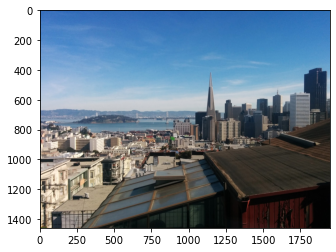

In [2]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("sf.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

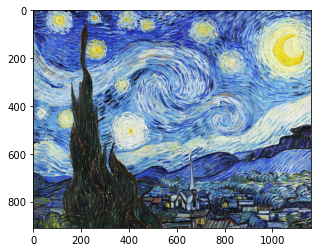

In [3]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("starry_night.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

In [4]:
import numpy as np

def preprocess_image(image_path):
    img = image.load_img(
        image_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [6]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [7]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [10]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [11]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 400
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        image.save_img(fname, img)

Iteration 10: loss=22720.43
Iteration 20: loss=14717.60
Iteration 30: loss=12382.09
Iteration 40: loss=11113.45
Iteration 50: loss=10267.53
Iteration 60: loss=9641.74
Iteration 70: loss=9151.01
Iteration 80: loss=8752.02
Iteration 90: loss=8419.31
Iteration 100: loss=8137.30
Iteration 110: loss=7894.93
Iteration 120: loss=7684.31
Iteration 130: loss=7499.58
Iteration 140: loss=7336.19
Iteration 150: loss=7190.72
Iteration 160: loss=7060.46
Iteration 170: loss=6943.22
Iteration 180: loss=6837.00
Iteration 190: loss=6740.41
Iteration 200: loss=6652.19
Iteration 210: loss=6571.31
Iteration 220: loss=6496.92
Iteration 230: loss=6428.18
Iteration 240: loss=6364.46
Iteration 250: loss=6305.26
Iteration 260: loss=6250.16
Iteration 270: loss=6198.67
Iteration 280: loss=6150.45
Iteration 290: loss=6105.24
Iteration 300: loss=6062.71
Iteration 310: loss=6022.60
Iteration 320: loss=5984.69
Iteration 330: loss=5948.80
Iteration 340: loss=5914.73
Iteration 350: loss=5882.41
Iteration 360: loss=5851

<function matplotlib.pyplot.show(close=None, block=None)>

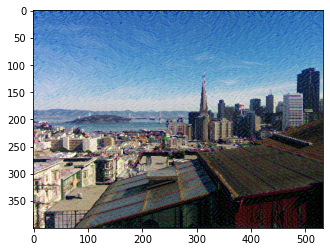

In [13]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_10.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

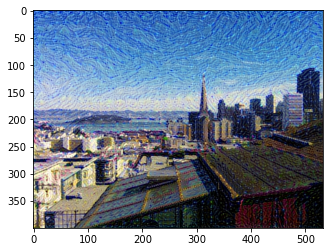

In [14]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_200.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

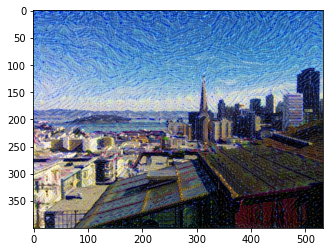

In [15]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_300.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

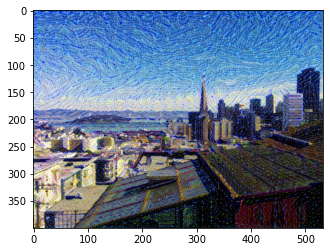

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("combination_image_at_iteration_400.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show